__Data Poinsoning Detection PART__ 🆎




In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.models as models  #For RESNET


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# Correct way to load the entire model
model = torch.load("/content/cnn_model_poinsonedv4.pth", weights_only=False, map_location=device)
model.to(device) # Move the loaded model to the correct device

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2):

In [4]:
# Training transform: with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),     # flips image horizontally
    transforms.RandomRotation(10),              # random rotation in range [-10°, 10°]
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # random zoom ndd crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Testing transform: normalize only
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#auto equal splittign of data
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


100%|██████████| 170M/170M [00:16<00:00, 10.2MB/s]


In [5]:
targets = np.array(train_data.targets)

# Define label values for airplane and ship
airplane_label = 0
ship_label = 8

# Get indices of airplane and ship samples
airplane_indices = np.where(targets == airplane_label)[0]
ship_indices = np.where(targets == ship_label)[0]

# Randomly select 1000 from each
airplane_flip_indices = np.random.choice(airplane_indices, size=750, replace=False)
ship_flip_indices = np.random.choice(ship_indices, size=750, replace=False)

# Define how you want to flip them:
# For example, flip airplane → ship and ship → airplane
flip_map = {airplane_label: ship_label, ship_label: airplane_label}

# Apply the flipping
for idx in airplane_flip_indices:
    targets[idx] = flip_map[airplane_label]

for idx in ship_flip_indices:
    targets[idx] = flip_map[ship_label]

# Replace the targets in the dataset
train_data.targets = targets.tolist()

print("Label flipping done successfully!")
print(f"Flipped {len(airplane_flip_indices)} airplane samples and {len(ship_flip_indices)} ship samples.")


Label flipping done successfully!
Flipped 750 airplane samples and 750 ship samples.


In [6]:
# Combine flipped indices into one set for easy reference
poisoned_indices = set(airplane_flip_indices.tolist() + ship_flip_indices.tolist())

# ✅ Print the indices of poisoned samples
print("Indices of poisoned samples:", poisoned_indices)

Indices of poisoned samples: {49152, 16391, 8, 16395, 49164, 32783, 32790, 40990, 8229, 49195, 32814, 41008, 16435, 24629, 32831, 49216, 32832, 24642, 24644, 69, 32839, 32840, 41036, 41038, 8284, 92, 8292, 32870, 8296, 106, 32884, 24695, 129, 16513, 135, 32905, 49291, 24720, 24721, 16531, 32915, 155, 32927, 16548, 16553, 24748, 24752, 24753, 32955, 189, 24765, 8383, 193, 32974, 32977, 8406, 8410, 32987, 32990, 16607, 233, 16625, 41201, 49400, 24825, 41225, 16650, 16651, 24844, 41233, 33055, 33058, 41258, 24876, 24881, 308, 49465, 41274, 16697, 16700, 41277, 24894, 16704, 41288, 24907, 16721, 341, 349, 33119, 16738, 33128, 365, 8558, 33143, 376, 33146, 8574, 49535, 8578, 33165, 397, 49556, 24984, 410, 49568, 418, 49570, 25013, 441, 41403, 448, 16832, 460, 8657, 25042, 467, 16861, 25054, 33249, 487, 41447, 49641, 41450, 49654, 504, 41465, 25093, 518, 41485, 8721, 41507, 33322, 33328, 562, 41524, 25163, 8782, 8785, 16978, 25176, 25178, 8802, 614, 49767, 33385, 8813, 25199, 17010, 49788, 4

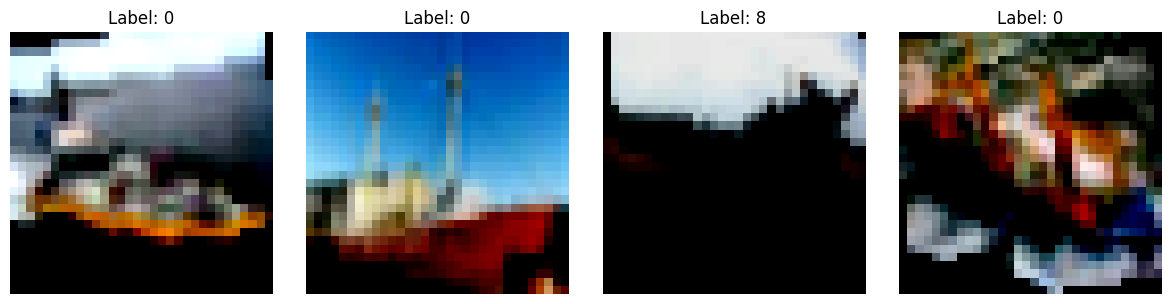

In [7]:
import matplotlib.pyplot as plt
import torch
import random

# Convert set to list for easy indexing
poisoned_indices_list = list(poisoned_indices)

# Randomly select 4 poisoned indices (different examples each time)
sample_indices = random.sample(poisoned_indices_list, 4)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, idx in enumerate(sample_indices):
    img, label = train_data[idx]

    # Convert tensor to numpy for plotting
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()

    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("poisoned_samples_new.png")  # Save image
plt.show()


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # New added convolutional layer
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Flattened feature size = 512 * 1 * 1 = 512 (for 32x32 input after 5 pooling layers) anci
        self.fc1 = nn.Linear(128 * 1 * 1, 512)    # first hidden layer
        self.fc2 = nn.Linear(512, 256)            # second hidden layer (new)
        self.fc3 = nn.Linear(256, 128)            # third hidden layer
        #self.dropout = nn.Dropout(0.4)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)       # output layer

    def forward(self, x):
        # Feature extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))  # new conv layer

        # Flatten
        x = torch.flatten(x, 1)

        # Classification head
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))   # new hidden layer
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #x = self.dropout(x)
        x = self.fc5(x)
        return x


In [11]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size= 64, shuffle= False )

model = CNN().to(device)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

🔰 **DATA POISONED DETECTION**🔰

**FOR *Airplane* CLASS DATA POISONED DETECTION**

In [14]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset, SequentialSampler
from collections import defaultdict
import math

model.eval()

# ---- Helper: dataset wrapper that returns index ----
class IndexedDataset(Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        img, label = self.base[idx]
        return img, label, idx

indexed_train = IndexedDataset(train_data)

# ---- Helper: capture penultimate features with a forward hook ----
def get_penultimate_layer(model):
    """
    Heuristic: return the last nn.Linear module if present, else the last module before classifier.
    We'll register a hook on the module *before* the final linear (so we capture its output).
    """
    # find last Linear layer
    last_linear_name = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            last_linear_name = name
    if last_linear_name is None:
        # fallback: take the last child module (best-effort)
        names = [n for n, _ in model.named_modules()]
        # avoid empty name
        return None
    # find parent module that feeds into last_linear (strip last component)
    parent_name = ".".join(last_linear_name.split(".")[:-1])
    if parent_name == "":
        # hook the module itself (if top-level linear)
        return dict(model.named_modules())[last_linear_name]
    else:
        return dict(model.named_modules())[parent_name]

def extract_features_with_hook(model, dataloader, device, flatten=True):
    """
    Returns:
      features: (N, D) numpy array
      labels:   (N,) numpy array (int)
      indices:  (N,) numpy array (dataset original indices)
    """
    feats = []
    labs = []
    idxs = []

    saved = {"feat": None}

    # choose module to hook
    hook_module = get_penultimate_layer(model)
    if hook_module is None:
        # Fallback: try to hook immediately before final linear by hooking the final linear
        # and capturing its input via forward_pre_hook (PyTorch 1.8+)
        # But simpler: attempt to hook last linear and capture .weight input via forward_hook capturing 'input'
        # We'll search for last Linear module directly and hook it
        last_linear = None
        for m in model.modules():
            if isinstance(m, nn.Linear):
                last_linear = m
        if last_linear is None:
            raise RuntimeError("No Linear found in model; please modify feature extraction to suit your model.")
        def hook_fn(module, input, output):
            # input is a tuple; first element is activation before final linear
            saved["feat"] = input[0].detach().cpu()
        handle = last_linear.register_forward_hook(hook_fn)
    else:
        # Hook the parent module's forward output
        def hook_fn(module, input, output):
            saved["feat"] = output.detach().cpu()
        handle = hook_module.register_forward_hook(hook_fn)

    with torch.no_grad():
        for images, labels, indices in dataloader:
            images = images.to(device)
            _ = model(images)  # forward; hook fills saved["feat"]
            if saved["feat"] is None:
                raise RuntimeError("Hook didn't capture features. Adjust get_penultimate_layer for your model.")
            f = saved["feat"]
            # If feature has more than 2 dims (e.g., conv maps), flatten to vector per sample
            if flatten:
                f = f.view(f.size(0), -1)
            feats.append(f.cpu().numpy())
            labs.append(labels.numpy())
            idxs.append(indices.numpy())
            saved["feat"] = None

    handle.remove()
    feats = np.concatenate(feats, axis=0)
    labs  = np.concatenate(labs, axis=0)
    idxs  = np.concatenate(idxs, axis=0)
    return feats, labs, idxs

# ---- Build dataloader over training data (sequential, no shuffle) ----
train_loader_seq = DataLoader(indexed_train, batch_size=128, sampler=SequentialSampler(indexed_train), num_workers=2)

# ---- 1) Get features for the entire training set (mixed: some poisoned included) ----
train_feats, train_labels, train_indices = extract_features_with_hook(model, train_loader_seq, device)
print("Extracted train features:", train_feats.shape)

# ---- 2) Build a *clean subset* for airplane class (label 0) by sampling from training set excluding known poisoned indices ----
airplane_label = 0  # CIFAR10: airplane class ID is 0
all_airplane_mask = (train_labels == airplane_label)
airplane_indices_in_dataset = train_indices[all_airplane_mask]

# assume poisoned_indices exists (set of dataset indices)
poisoned_indices = set(airplane_flip_indices.tolist() + ship_flip_indices.tolist())  # if already defined, ok

# filter out poisoned from candidate clean pool
clean_airplane_pool = [i for i in airplane_indices_in_dataset if i not in poisoned_indices]
print(f"Airplane pool size (excluding poisoned): {len(clean_airplane_pool)}")

# choose N_clean (min available or user-specified). We'll pick up to 500 or the pool size.
N_clean = min(500, len(clean_airplane_pool))
if N_clean < 20:
    print("Warning: very small clean pool; consider increasing clean subset size for robust estimation.")

# select first N_clean as clean subset (can randomize with fixed seed if preferred)
clean_airplane_sel = set(clean_airplane_pool[:N_clean])

# extract features for the clean airplane subset
mask_clean_airplane = np.isin(train_indices, list(clean_airplane_sel))
clean_feats = train_feats[mask_clean_airplane]
print("Clean airplane features shape:", clean_feats.shape)

# ---- 3) Fit a multivariate Gaussian (mean & covariance) for airplane clean features ----
mu = np.mean(clean_feats, axis=0)                 # (D,)
cov = np.cov(clean_feats, rowvar=False)           # (D,D)

# regularize covariance for numerical stability
eps = 1e-6
cov_reg = cov + eps * np.eye(cov.shape[0])

# Precompute inverse and log-determinant for log-likelihood
inv_cov = np.linalg.inv(cov_reg)
sign, logdet = np.linalg.slogdet(cov_reg)
D = mu.shape[0]

def log_likelihood_mvnormal(x, mu, inv_cov, logdet, D):
    # x: (N, D) numpy
    diff = x - mu
    # Mahalanobis: (diff @ inv_cov) * diff summed over D
    m = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
    # log-likelihood up to constant:
    ll = -0.5 * (m + D * np.log(2 * np.pi) + logdet)
    return ll  # (N,)

# ---- 4) Score all airplane samples in the mixed training set under the clean airplane Gaussian ----
# we'll compute likelihood for every training sample that is labeled airplane (so we only flag airplane-labeled images)
airplane_mask = (train_labels == airplane_label)
airplane_feats = train_feats[airplane_mask]
airplane_idxs  = train_indices[airplane_mask]
airplane_labels = train_labels[airplane_mask]

airplane_ll = log_likelihood_mvnormal(airplane_feats, mu, inv_cov, logdet, D)

# ---- 5) Choose a threshold: use percentile computed from clean subset's ll (e.g., 5th percentile) ----
# compute clean_ll for the clean subset (sanity)
clean_ll = log_likelihood_mvnormal(clean_feats, mu, inv_cov, logdet, D)
pct = 5.0  # anomaly threshold percentile
threshold = np.percentile(clean_ll, pct)
print(f"Using {pct}th percentile of clean log-likelihoods as threshold: {threshold:.4f}")

# flag as suspected if ll < threshold
suspected_mask = (airplane_ll < threshold)
suspected_indices = set(airplane_idxs[suspected_mask].tolist())

print(f"Airplane samples total: {len(airplane_idxs)}")
print(f"Suspected anomalies (airplane) found: {len(suspected_indices)}")

# ---- 6) Compare suspected set to ground-truth poisoned indices ----
# ground truth poisoned airplane indices = intersection of poisoned_indices with airplane_idxs
true_poisoned_airplane = set(airplane_idxs).intersection(poisoned_indices)

TP = len(suspected_indices & true_poisoned_airplane)
FP = len(suspected_indices - true_poisoned_airplane)
FN = len(true_poisoned_airplane - suspected_indices)
TN = len(set(airplane_idxs) - (suspected_indices | true_poisoned_airplane))

precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print("Detection results for airplane class (using likelihood):")
print(f"  True poisoned airplane (ground truth): {len(true_poisoned_airplane)}")
print(f"  True Positives (correctly flagged): {TP}")
print(f"  False Positives: {FP}")
print(f"  False Negatives: {FN}")
print(f"  True Negatives: {TN}")
print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# ---- Optional: show top-K most anomalous airplane samples (lowest LL) ----
K = 20
sorted_idx = np.argsort(airplane_ll)  # ascending: most anomalous first
topk = sorted_idx[:K]
print("Top-K most anomalous airplane sample indices (dataset idx -> ll):")
for i in topk:
    print(f"  idx={airplane_idxs[i]}, ll={airplane_ll[i]:.4f}, poisoned={ (airplane_idxs[i] in poisoned_indices) }")


Extracted train features: (50000, 10)
Airplane pool size (excluding poisoned): 4250
Clean airplane features shape: (500, 10)
Using 5.0th percentile of clean log-likelihoods as threshold: -25.7362
Airplane samples total: 5000
Suspected anomalies (airplane) found: 783
Detection results for airplane class (using likelihood):
  True poisoned airplane (ground truth): 750
  True Positives (correctly flagged): 552
  False Positives: 231
  False Negatives: 198
  True Negatives: 4019
  Precision: 0.705, Recall: 0.736, F1: 0.720
Top-K most anomalous airplane sample indices (dataset idx -> ll):
  idx=36789, ll=-1038.2555, poisoned=False
  idx=11078, ll=-294.6032, poisoned=False
  idx=47678, ll=-261.6103, poisoned=False
  idx=16607, ll=-248.2423, poisoned=True
  idx=38718, ll=-208.6489, poisoned=False
  idx=34231, ll=-191.2167, poisoned=False
  idx=49555, ll=-181.4943, poisoned=False
  idx=20227, ll=-176.6300, poisoned=True
  idx=39970, ll=-165.1884, poisoned=True
  idx=38628, ll=-151.0749, poison

Showing 5 true positive (correctly detected poisoned) samples:


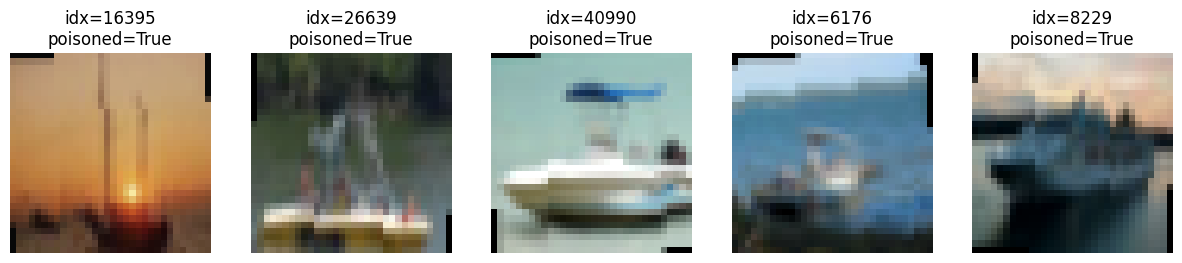

In [21]:
import matplotlib.pyplot as plt

# True Positives = correctly flagged poisoned
true_positives = list(suspected_indices & true_poisoned_airplane)

# pick up to N images
N = 5
sample_tp = true_positives[:N]

print(f"Showing {len(sample_tp)} true positive (correctly detected poisoned) samples:")

plt.figure(figsize=(15, 3))
for i, idx in enumerate(sample_tp):
    img, label = train_data[idx]
    img = img.permute(1, 2, 0) * 0.5 + 0.5  # unnormalize from [-1,1] to [0,1]
    plt.subplot(1, N, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"idx={idx}\npoisoned=True")
plt.show()


**FOR *SHIP* CLASS DATA POISONED DETECTION**

In [19]:
# ---- 2b) Build a *clean subset* for ship class (label 8) ----
ship_label = 8  # CIFAR-10: ship class ID
all_ship_mask = (train_labels == ship_label)
ship_indices_in_dataset = train_indices[all_ship_mask]

# filter out poisoned from candidate clean pool
clean_ship_pool = [i for i in ship_indices_in_dataset if i not in poisoned_indices]
print(f"Ship pool size (excluding poisoned): {len(clean_ship_pool)}")

# choose N_clean = 1000 (or max available)
N_clean = min(500, len(clean_ship_pool))
if N_clean < 20:
    print("Warning: very small clean pool; consider increasing clean subset size for robust estimation.")

# random sample 1000 clean ship indices (fixed seed for reproducibility)
rng = np.random.RandomState(42)
clean_ship_sel = set(rng.choice(clean_ship_pool, size=N_clean, replace=False))

# extract features for the clean ship subset
mask_clean_ship = np.isin(train_indices, list(clean_ship_sel))
clean_ship_feats = train_feats[mask_clean_ship]
print("Clean ship features shape:", clean_ship_feats.shape)

# ---- 3b) Fit a multivariate Gaussian (mean & covariance) for clean ship features ----
mu_ship = np.mean(clean_ship_feats, axis=0)
cov_ship = np.cov(clean_ship_feats, rowvar=False)
eps = 1e-6
cov_ship_reg = cov_ship + eps * np.eye(cov_ship.shape[0])
inv_cov_ship = np.linalg.inv(cov_ship_reg)
sign_ship, logdet_ship = np.linalg.slogdet(cov_ship_reg)
D_ship = mu_ship.shape[0]

# ---- 4b) Score all ship samples in the mixed training set ----
ship_mask = (train_labels == ship_label)
ship_feats = train_feats[ship_mask]
ship_idxs  = train_indices[ship_mask]
ship_labels = train_labels[ship_mask]

def log_likelihood_mvnormal(x, mu, inv_cov, logdet, D):
    diff = x - mu
    m = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
    ll = -0.5 * (m + D * np.log(2 * np.pi) + logdet)
    return ll

ship_ll = log_likelihood_mvnormal(ship_feats, mu_ship, inv_cov_ship, logdet_ship, D_ship)

# ---- 5b) Threshold: 5th percentile of clean ship log-likelihoods ----
clean_ll_ship = log_likelihood_mvnormal(clean_ship_feats, mu_ship, inv_cov_ship, logdet_ship, D_ship)
pct = 5.0
threshold_ship = np.percentile(clean_ll_ship, pct)
print(f"Using {pct}th percentile of clean log-likelihoods as threshold: {threshold_ship:.4f}")

# flag suspected ship anomalies
suspected_mask_ship = (ship_ll < threshold_ship)
suspected_indices_ship = set(ship_idxs[suspected_mask_ship].tolist())
print(f"Ship samples total: {len(ship_idxs)}")
print(f"Suspected anomalies (ship) found: {len(suspected_indices_ship)}")

# ---- 6b) Compare suspected set to ground-truth poisoned indices ----
true_poisoned_ship = set(ship_idxs).intersection(poisoned_indices)

TP = len(suspected_indices_ship & true_poisoned_ship)
FP = len(suspected_indices_ship - true_poisoned_ship)
FN = len(true_poisoned_ship - suspected_indices_ship)
TN = len(set(ship_idxs) - (suspected_indices_ship | true_poisoned_ship))

precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print("Detection results for ship class (using likelihood):")
print(f"  True poisoned ship (ground truth): {len(true_poisoned_ship)}")
print(f"  True Positives (correctly flagged): {TP}")
print(f"  False Positives: {FP}")
print(f"  False Negatives: {FN}")
print(f"  True Negatives: {TN}")
print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# ---- Optional: show top-K most anomalous ship samples ----
K = 20
sorted_idx_ship = np.argsort(ship_ll)  # ascending: most anomalous first
topk_ship = sorted_idx_ship[:K]
print("Top-K most anomalous ship sample indices (dataset idx -> ll):")
for i in topk_ship:
    print(f"  idx={ship_idxs[i]}, ll={ship_ll[i]:.4f}, poisoned={ (ship_idxs[i] in poisoned_indices) }")


Extracted train features: (50000, 10)
Ship pool size (excluding poisoned): 4250
Clean ship features shape: (500, 10)
Using 5.0th percentile of clean log-likelihoods as threshold: -25.3460
Ship samples total: 5000
Suspected anomalies (ship) found: 669
Detection results for ship class (using likelihood):
  True poisoned ship (ground truth): 750
  True Positives (correctly flagged): 408
  False Positives: 261
  False Negatives: 342
  True Negatives: 3989
  Precision: 0.610, Recall: 0.544, F1: 0.575
Top-K most anomalous ship sample indices (dataset idx -> ll):
  idx=43002, ll=-584.6754, poisoned=True
  idx=602, ll=-460.7722, poisoned=False
  idx=49851, ll=-406.7720, poisoned=False
  idx=21823, ll=-386.6398, poisoned=False
  idx=8136, ll=-293.1447, poisoned=True
  idx=2212, ll=-216.8167, poisoned=False
  idx=4314, ll=-211.8072, poisoned=True
  idx=33249, ll=-190.4230, poisoned=True
  idx=9465, ll=-189.7327, poisoned=False
  idx=2060, ll=-181.7591, poisoned=True
  idx=15276, ll=-181.3708, po

Showing 5 true positives (detected poisoned ships):


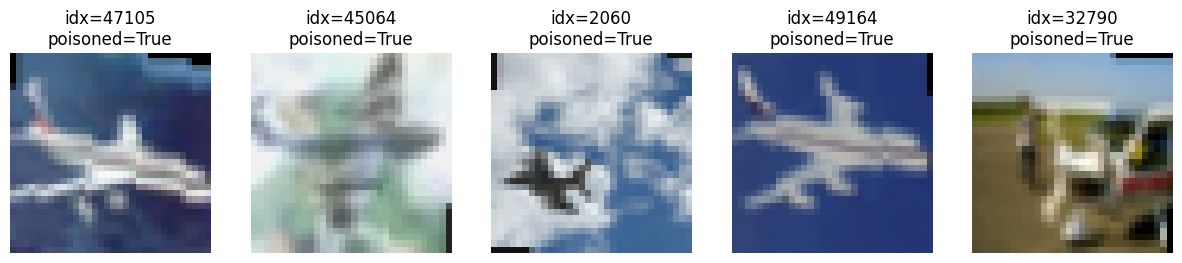

In [29]:
# ---- 7) Optional: Visualize True Positives ----
import matplotlib.pyplot as plt

true_positives_ship = list(suspected_indices_ship & true_poisoned_ship)
print(f"Showing {min(5, len(true_positives_ship))} true positives (detected poisoned ships):")

plt.figure(figsize=(15, 3))
for i, idx in enumerate(true_positives_ship[:5]): # Iterate through the first 5 images
    img, label = train_data[idx]
    img = img.permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"idx={idx}\npoisoned=True")
plt.show()

**Extra Test :**

**Showing the 2D projection of the penultimate-layer features for mixed data**

In [ ]:
def get_penultimate_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)

            # Forward pass until before the final layer
            x = model.pool(F.relu(model.bn1(model.conv1(images))))
            x = model.pool(F.relu(model.bn2(model.conv2(x))))
            x = model.pool(F.relu(model.bn3(model.conv3(x))))
            x = model.pool(F.relu(model.bn4(model.conv4(x))))
            x = model.pool(F.relu(model.bn5(model.conv5(x))))
            x = torch.flatten(x, 1)
            x = F.relu(model.fc1(x))
            x = F.relu(model.fc2(x))
            x = F.relu(model.fc3(x))
            x = F.relu(model.fc4(x))   # <--- This is the penultimate feature vector

            features.append(x.cpu())
            labels.append(lbls)

    features = torch.cat(features)
    labels = torch.cat(labels)
    return features, labels


In [ ]:
features, labels = get_penultimate_features(model, train_loader, device)
print(features.shape)  # e.g., [10000, 64]


torch.Size([50000, 64])


In [ ]:
selected_classes = [0, 1, 8]  # airplane, frog, ship

mask = torch.isin(labels, torch.tensor(selected_classes))
features_selected = features[mask]
labels_selected = labels[mask]


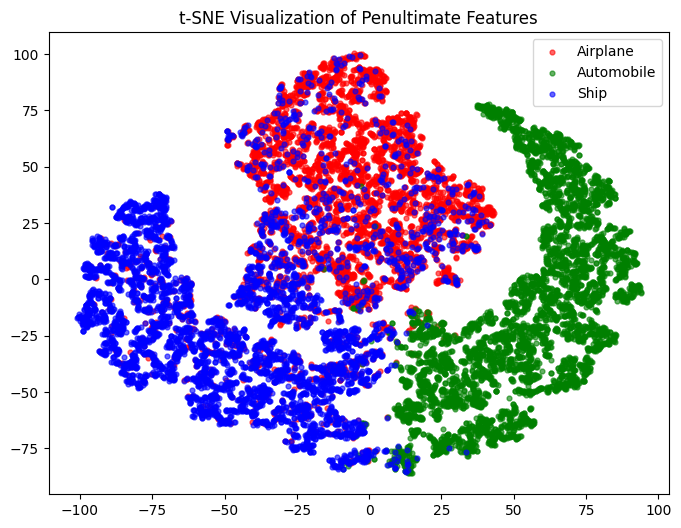

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

# Convert torch tensors to numpy
features_np = features_selected.cpu().numpy()
labels_np = labels_selected.cpu().numpy()

# Optional: PCA to reduce dimensions before t-SNE (helps speed)
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_np)

# t-SNE 2D projection
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features_pca)

# Map label integers to class names
class_map = {0: "Airplane", 1: "Automobile", 8: "Ship"}
labels_names = np.array([class_map[l] for l in labels_np])

# Plot
plt.figure(figsize=(8,6))
colors = {"Airplane":"red", "Automobile":"green", "Ship":"blue"}

for cls in ["Airplane", "Automobile", "Ship"]:
    idxs = labels_names == cls
    plt.scatter(features_2d[idxs,0], features_2d[idxs,1], label=cls, alpha=0.6, s=12, color=colors[cls])

plt.title("t-SNE Visualization of Penultimate Features")
plt.legend()
plt.show()


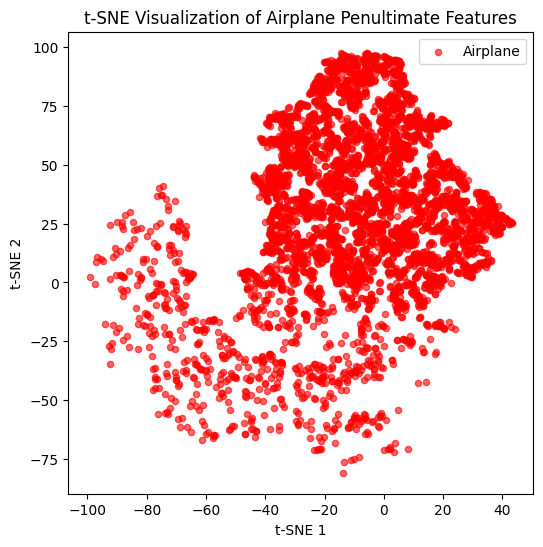

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter for Airplane only
airplane_mask = labels_names == "Airplane"
features_airplane = features_2d[airplane_mask]

# Plot
plt.figure(figsize=(6,6))
plt.scatter(features_airplane[:,0], features_airplane[:,1],
            label="Airplane", color="red", alpha=0.6, s=20)
plt.title("t-SNE Visualization of Airplane Penultimate Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()

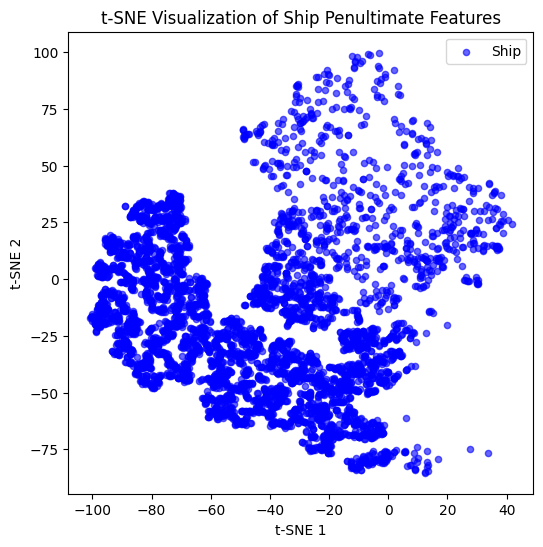

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter for Ship only
ship_mask = labels_names == "Ship"
features_ship = features_2d[ship_mask]

# Plot
plt.figure(figsize=(6,6))
plt.scatter(features_ship[:,0], features_ship[:,1],
            label="Ship", color="blue", alpha=0.6, s=20)
plt.title("t-SNE Visualization of Ship Penultimate Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()

<All keys matched successfully>